In [1]:
%matplotlib inline

import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import time
import random

from collections import defaultdict

from blackjack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation, k=1):
        epsilon = np.sqrt(k)/k
        #if k % 100000 == 0: print(epsilon)
        #if k % 50 == 0:
        #    k_mod /= 10
        probs = np.zeros(nA)
        score, dealer_score, usable_ace = observation
#         if score >= 20: 
#             probs[0] = 1-epsilon+(epsilon/nA)
#             probs[1] = epsilon/nA
#         else:
#             probs[0] = epsilon/nA
#             probs[1] = 1-epsilon+(epsilon/nA)
            
#         policy_s = np.ones(nA) * epsilon / nA
#         best_a = np.argmax(Q[observation])
#         policy_s[best_a] = 1 - epsilon + (epsilon / nA)
        
        best_a = np.argmax(Q[observation])
        random_a = random.randint(0, nA - 1)
        return np.random.choice([best_a, random_a], p=[1 - epsilon + (epsilon / nA), epsilon / nA])
#         return policy_s
#         return probs
    return policy_fn

In [4]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    returns_mean = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(1, num_episodes + 1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        episode = []
        observation_state = env.reset() # state
        for t in range(100):
            action = policy(observation_state, k=i_episode)
            #action = np.argmax(action_probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((observation_state, action, reward))
            #Q[observation_state] = action_probs
            if done:
                break
            observation_state = next_state
            
        ###############################################################################################
        # Find all states the we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        states_in_episode = set([tuple(x[0]) for x in episode])
        for state in states_in_episode:
            # Find the first occurance of the state in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[state] += G
            returns_count[state] += 1.0
            returns_mean[state] = returns_sum[state] / returns_count[state]
            
            Q[state][action] = Q[state][action] + (1/returns_count[state])*(G-Q[state][action])
            
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    
    # Print min, max, mean, std for all rewards stored in returns_mean
    #print("\nMin reward: {}".format( np.min(list(returns_mean.values())) ))
    #print("Max reward: {}".format( np.max(list(returns_mean.values())) ))
    #print("Mean reward: {}".format( np.mean(list(returns_mean.values())) ))
    #print("Std reward: {}".format( np.std(list(returns_mean.values())) ))
    
    return Q, policy, returns_mean

Episode 10000/10000.

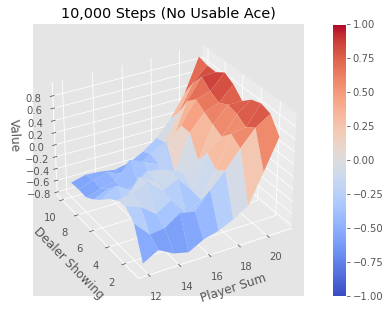

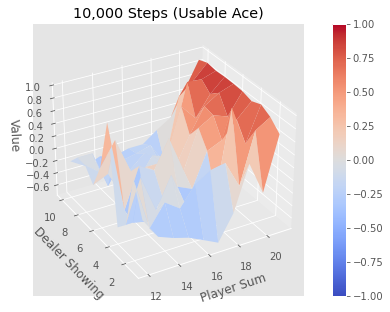

Episode 50000/50000.

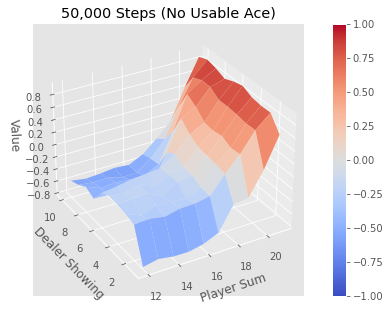

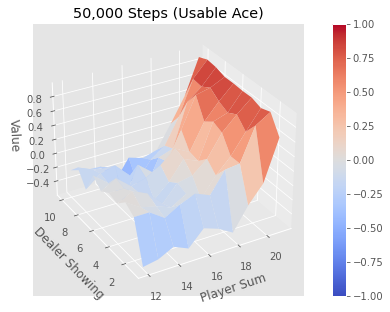

Episode 100000/100000.

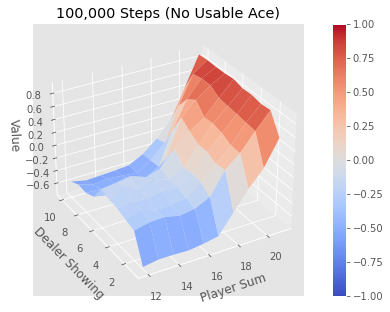

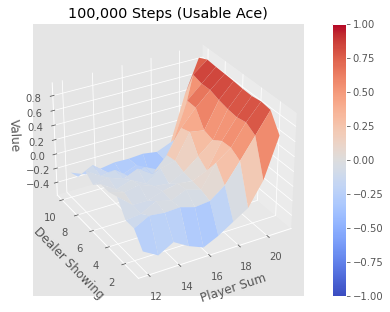

Episode 300000/300000.

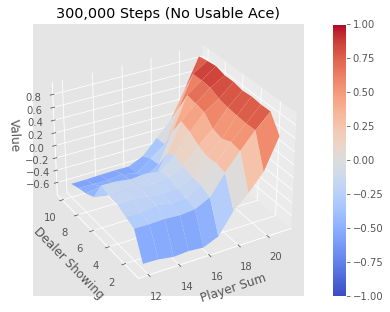

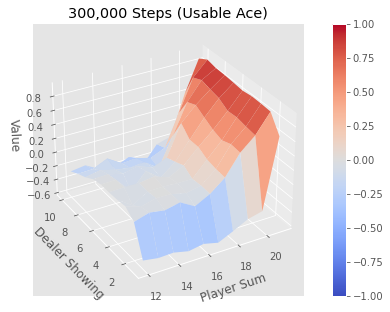

Episode 400000/400000.

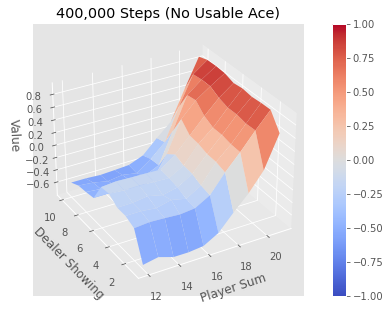

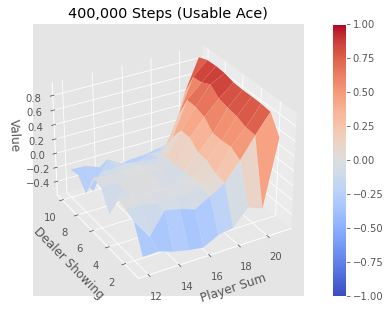

Episode 500000/500000.

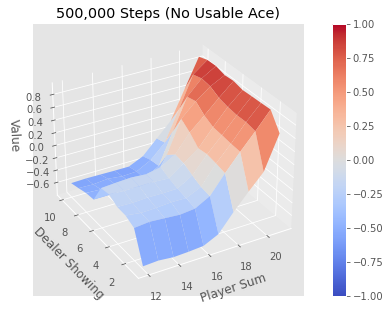

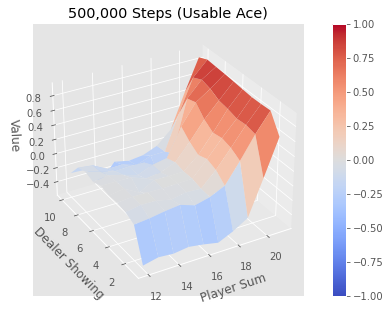

Episode 500000/500000.
 1267.0625 s


In [5]:
start = time.process_time()

mean_returns = {}
time_steps = [10000, 50000, 100000, 300000, 400000, 500000]
for ts in time_steps:
    for i in range(10):
        num_episodes = ts
        Q, policy, V = mc_control_epsilon_greedy(env, num_episodes, epsilon=1)
        if num_episodes in mean_returns: mean_returns[num_episodes].append(np.mean(list(V.values())))
        else: mean_returns[num_episodes] = [np.mean(list(V.values()))]
        
        if i == 0:
            plotting.plot_value_function(V, title=f'{ts:,} Steps', figsize=(10,5))

end = time.process_time()
print("\n",end - start,"s")

Text(0, 0.5, 'Average return')

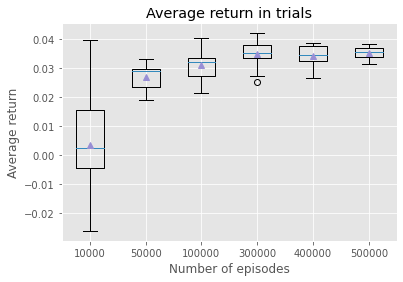

In [9]:
fig, ax = plt.subplots()
bp = ax.boxplot(mean_returns.values(), showmeans=True, labels=mean_returns.keys())
ax.set_title('Average return in trials')
ax.set_xlabel('Number of episodes')
ax.set_ylabel('Average return')

In [7]:
policy

{(15, 10, False): 0,
 (12, 8, False): 0,
 (15, 9, True): 1,
 (18, 10, False): 0,
 (17, 8, False): 0,
 (16, 10, False): 0,
 (18, 10, True): 0,
 (16, 3, False): 0,
 (12, 2, False): 0,
 (16, 9, False): 0,
 (14, 9, False): 0,
 (15, 8, False): 0,
 (15, 8, True): 0,
 (16, 8, True): 0,
 (12, 3, False): 0,
 (21, 6, True): 0,
 (14, 1, False): 0,
 (20, 9, True): 0,
 (15, 6, False): 0,
 (14, 7, False): 0,
 (12, 6, False): 0,
 (16, 4, False): 0,
 (19, 3, False): 0,
 (20, 10, False): 0,
 (19, 10, True): 1,
 (17, 10, False): 0,
 (20, 2, True): 0,
 (15, 4, False): 0,
 (18, 7, False): 0,
 (13, 10, False): 0,
 (15, 5, False): 0,
 (13, 6, False): 0,
 (12, 7, False): 0,
 (15, 7, False): 0,
 (16, 1, False): 0,
 (19, 6, False): 0,
 (15, 1, False): 0,
 (20, 4, False): 0,
 (19, 10, False): 0,
 (13, 7, False): 0,
 (12, 5, False): 0,
 (19, 8, False): 0,
 (19, 4, False): 0,
 (13, 9, False): 0,
 (18, 3, False): 0,
 (13, 3, False): 0,
 (21, 5, True): 0,
 (14, 10, True): 0,
 (18, 1, False): 0,
 (18, 4, False): 0,


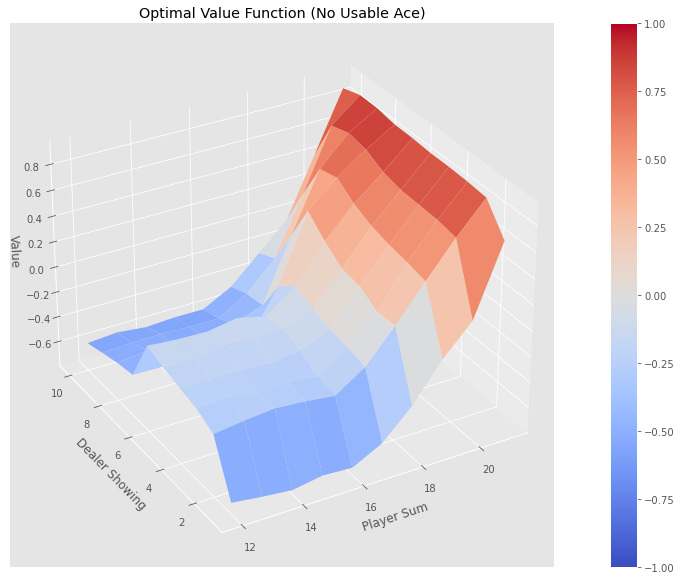

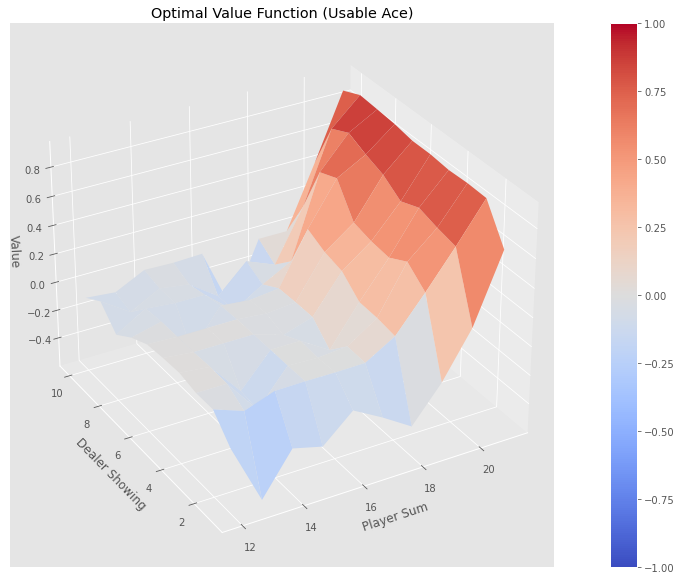

In [67]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

In [14]:
list(Q.items())[-30:]

[((17, 9, True), array([-0.14387699, -0.02941176])),
 ((15, 6, True), array([0.0093985, 0.       ])),
 ((18, 4, True), array([0.12732475, 0.        ])),
 ((13, 7, True), array([-0.03046448, -0.03625346])),
 ((20, 1, True), array([0.16391509, 0.        ])),
 ((16, 5, True), array([-0.01227198, -0.00182149])),
 ((15, 7, True), array([-0.03839122,  0.        ])),
 ((12, 5, True), array([0.00862069, 0.        ])),
 ((12, 1, True), array([-0.46524109, -0.13617883])),
 ((16, 3, True), array([-0.03790614,  0.        ])),
 ((15, 2, True), array([-0.01454545,  0.        ])),
 ((13, 1, True), array([-0.35491358, -0.19734156])),
 ((14, 8, True), array([-0.13518991, -0.00255754])),
 ((17, 1, True), array([-0.54001376, -0.52811531])),
 ((12, 9, True), array([-0.10300429,  0.        ])),
 ((18, 8, True), array([0.12337662, 0.        ])),
 ((13, 9, True), array([-0.11492025, -0.02631579])),
 ((19, 6, True), array([0.5451664, 0.       ])),
 ((12, 8, True), array([-0.04300292, -0.00507614])),
 ((13, 4,